# Projet d'image: Recalage $l^2 - l^1$

#### Chargement des packages

In [1]:
from __future__ import division

import math as math
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

from PIL import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

## La fonction énergie:
Pour faire notre recalage d'image on va devoir minimiser l'energie suivante:
$$ E(t) = D(t) + \lambda .R_{\epsilon}(t) $$

On commence par définir les fonctions de bases

In [2]:
def grad_x(img, adjoint):
    sx , sy = np.shape(img)
    diff_x = np.copy(img)
    
    if adjoint==0:
        for x in range(sx):
            if x==sx-1:
                xnext=0
            else:
                xnext=x+1
            for y in range(sy):
                diff_x[x,y] = img[xnext,y]- img[x,y]
    else: 
        for x in range(sx):
            if x==0:
                xprev=sx-1
            else:
                xprev=x-1
            for y in range(sy):
                diff_x[x,y] = img[xprev,y]- img[x,y]
    
    return diff_x
    
def grad_y(img, adjoint):
    sx , sy = np.shape(img)
    diff_y =  np.copy(img)

    if adjoint==0:
       
        for y in range(sy):
            if y==sy-1:
                ynext=0
            else:
                ynext=y+1
            for x in range(sx):
                diff_y[x,y] = img[x,ynext]- img[x,y]
    else:
        for y in range(sy):
            if y==0:
                yprev=sy-1
            else:
                yprev=y-1
            for x in range(sx):
                diff_y[x,y] = img[x,yprev]- img[x,y]
    
    return diff_y

def grad(v): # gradien de l'image
    gr = [grad_x(v,0),grad_y(v,0)]
    return 

La fonction D attachée aux données s'écrit comme ceci:

$$D(t) = \sum_{m,n=1}^{N}{(\tilde{v}^1((m,n)+t_{m,n})-v_{m,n}^2})^2 \rm\ \rm\ avec, \rm\ \rm\
\tilde{v}^1((m,n)+ t_{m,n}) = v_{m,n}^1 +\langle    \nabla v_{m,n}^1, t_{m,n}\rangle$$

In [3]:
# on definit la fonction D

def M(t,v1):
    t1 = t[0,:,:]
    t2 = t[1,:,:]
    dx = grad_x(v1,0)
    dy = grad_y(v1,0)
    return dx*t1 + dy*t2

def M_adjoint(s,v):
    dx = grad_x(v,0)
    dy = grad_y(v,0)
    m,n = v.shape
    A = np.zeros((2,m,n))
    A[0,:,:] = dx * s
    A[1,:,:] = dy * s
    return A

def D(t,v1,v2):
    return np.linalg.norm(v1 - v2 + M(t,v1))**2

def grad_D(t,v1,v2): # gradient de D(t)
    return 2*M_adjoint(M(t,v1),v1)+2*M_adjoint(v1,v1)-2*M_adjoint(v2,v1)   

La fonction R de regularisation s'écrit comme ceci:
$$R_{\epsilon}(t) = \sum_{m,n=1}^{N}{\sqrt{|\nabla t_{m,n}^1|^2 + |\nabla t_{m,n}^2| + \epsilon}}$$

In [4]:
# on definit la fonction R

def phi(v1,v2,eps): # fonction phi 
    return np.sqrt(v1 + v2 + eps)

def grad_phi(v1,v2,eps): # gradient de phi
    return np.sqrt(1/(4*(v1 + v2 + eps)))

def R(t,eps,Lambda): # fonction de regularisation
    t1 = t[0,:,:]
    t2 = t[1,:,:]
    a = grad_x(t1,0)
    b = grad_x(t2,0)
    c = grad_y(t1,0)
    d = grad_y(t2,0)
    
    grad_t1 = a**2 + c**2
    grad_t2 = b**2 + d**2
    res = Lambda*np.sum(phi(grad_t1,grad_t2,eps))
    return res

def grad_R(t,eps,Lambda): # gradient de R
    d, m, n = t.shape

    t1 = t[0,:,:]
    t2 = t[1,:,:]
    
    grad = np.zeros((d, m, n))

    a = grad_x(t1,0)
    b = grad_x(t2,0)
    c = grad_y(t1,0)
    d = grad_y(t2,0)
    
    X1 = 2*grad_phi(a**2,c**2 ,eps)*grad_x(t1,0)
    X2 = 2*grad_phi(b**2,d**2,eps)*grad_y(t1,0)
    Y1 = 2*grad_phi(a**2,c**2 ,eps)*grad_x(t2,0)
    Y2 = 2*grad_phi(b**2,d**2,eps)*grad_y(t2,0)

    grad[0,:,:] = grad_x(X1,1)+grad_y(Y1,1)
    grad[1,:,:] = grad_x(X2,1)+grad_y(Y2,1)

    
    return Lambda*grad

On définit donc l'energie E et son gradient 

In [5]:
# on définit l'energie E
def E(t,v1,v2,eps,Lambda):
    term1 = D(t,v1,v2)
    term2 = R(t,eps,Lambda)
    return  term1 + term2 

def grad_E(t,v1,v2,eps,Lambda):
    return grad_D(t,v1,v2) + grad_R(t,eps,Lambda)

## L'algorithme de descente de gradient

Pour minimiser notre énergie on va utiliser 2 descentes de gradient différentes:

### La descente de gradient à pas constant

In [101]:
def descente_grad(v1,v2,pas,nbIter,eps,Lambda): # algorithme de la descente de gradient avec pas constant
    # initialisation
    m,n = v1.shape
    t = np.zeros((2,m,n))
    l2=8*Lambda*(eps**(-1/2))
    l1=2
    pas=1/(l1+l2)
    norm_grad = []

    for it in range(nbIter):
        d = grad_E(t,v1,v2,eps,Lambda)
        t = t - pas * d # nouveau champs de vecteurs
        norm_grad += [np.sqrt(np.linalg.norm(d[0],2)**2 + np.linalg.norm(d[1],2)**2)]
        
    return t,norm_grad

### La descente de gradient avec le pas d'Armijo

In [119]:
def descente_gradA(v1,v2,nbiter,eps,Lambda): # algorithme de la descente de gradient avec pas d'Armijo
    m,n = v1.shape
    t = np.zeros((2,m,n))
    
    sigma = 10**(-6)
    b = 0.1
    func = []
    norm_grad = []
    for it in range(nbiter):

        # initialisation
        pas = 1
        nb = 0
        d = grad_E(t,v1,v2,eps,Lambda)

        while E(t,v1,v2,eps,Lambda) - E(t-pas*d,v1,v2,eps,Lambda) < sigma*pas*(np.sqrt(np.linalg.norm(d[0],2)**2+np.linalg.norm(d[1],2)**2)): # condition d'Armijo
            pas *= b # diminution du pas
            nb += 1
        
        t = t - pas * d # nouveau champs de vecteurs
        norm_grad += [np.sqrt(np.linalg.norm(d[0],2)**2 + np.linalg.norm(d[1],2)**2)]
        func.append(E(t,v1,v2,eps,Lambda))
    return t,norm_grad,func

## Fonctions d'affichage

In [8]:
def draw_arrows(Image,t,N,taille,style,Lambda,impor,meth):
    k ,l = np.shape(Image)
    
    
    X, Y = np.meshgrid(np.arange(0, k, 1), np.arange(0, l, 1))
    U = np.zeros((int(X.shape[0]/N),int(X.shape[1]/N)))
    V = np.zeros((int(X.shape[0]/N),int(X.shape[1]/N)))
    x = np.zeros((int(X.shape[0]/N),int(X.shape[1]/N)))
    y = np.zeros((int(X.shape[0]/N),int(X.shape[1]/N)))
    r = np.sqrt(N**2 + N**2)/2  
    tcop = np.copy(t)

    tcop[0,:,:] = tcop[0,:,:]*k*l
    tcop[1,:,:] = tcop[1,:,:]*k*l
    
    
    a=0.5
    
    for i in range(int(X.shape[0]/N)):
        for j in range(int(X.shape[1]/N)):
            x[i,j] = X[i*N,j*N]
            y[i,j] = Y[i*N,j*N]
            
            if style == 1:
                U[i,j] = np.sum(tcop[0,i*N:(i+1)*N,j*N:(j+1)*N])/N
                V[i,j] = np.sum(tcop[1,i*N:(i+1)*N,j*N:(j+1)*N])/N
                if meth == 1:
                    cst = N*(100/Lambda)
                    f = 1
                else:
                    cst = N*(1/(taille*Lambda))
                    f = 10
            else:
                U[i,j] = tcop[0,i*N,j*N] # moyenne du déplacement horizontal entre deux points du quadrillage
                V[i,j] = tcop[1,i*N,j*N] # moyenne du déplacement vertical entre deux points du quadrillage
                if meth == 1:
                    cst = 10**(-3)*(100/Lambda)
                    f = 1
                else:
                    cst = 10**(-3)*(1/(taille*Lambda))
                    f = 5
            # mise à zéro des premières et dernières lignes car pb de bords 
            if N < 14: # si quadrillage grand, on enlève les 2 premières et les 2 dernières lignes
                # les problèmes de bords sont plus étendues
                if i == 0 or i == int(X.shape[0]/N-1) or i == 1 or i == int(X.shape[0]/N-2):
                     U[i,j] = V[i,j] = 0
            else: # si quadrillage petit, on enlève la première et la dernière ligne
                if i == 0 or i == int(X.shape[0]/N-1):
                    U[i,j] = V[i,j] = 0
                    
            if np.abs(U[i,j]) <= cst and np.abs(V[i,j]) <= cst:
                # affichage d'un point si le mouvement est trop faible
                # U[i,j] = V[i,j]=0
                plt.arrow(x[i,j],y[i,j],0,0,head_width=0.1*r,head_length=0.05*r,color='pink')
            
            else: # affichage d'une flèche orienté par le mouvement sinon
                val = np.sqrt((V[i,j]**2+(U[i,j]**2))) # calcul de la norme du vecteur au point
                dt = np.sqrt(r**2/(1+val**2))
                if impor == 1:
                    plt.arrow(x[i,j],y[i,j],-f*V[i,j]*dt*taille,-f*U[i,j]*dt*taille,width = 0.01,head_width=(a)*r,head_length=(a/2)*r,color='pink')
                else:
                    plt.arrow(x[i,j],y[i,j],taille*f*V[i,j]*dt/val,taille*f*U[i,j]*dt/val,width = 0.01,head_width=(a)*r,head_length=(a/2)*r,color='pink')
    plt.imshow(Image, cmap = 'gray')
    return(None)
   

## Test sur image

### Décalage de Barbara

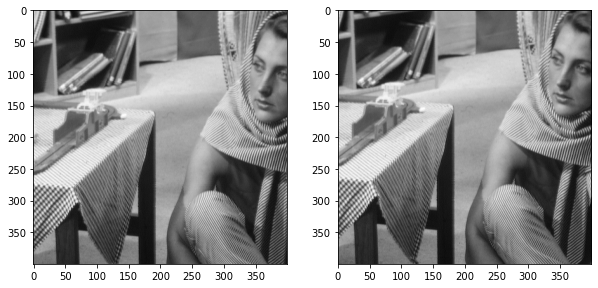

In [9]:
#image 1 
v1 = mpimg.imread("barbara.png")[0:400,0:400]
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(v1,cmap='gray')
#image 2
v2 = mpimg.imread("barbara.png")[10:410,10:410]
plt.subplot(1,2,2)
plt.imshow(v2,cmap='gray')
plt.show()

#### Test avec pas constant 

##### $\lambda = 100$

In [10]:
Lambda = 100
t_vc,norm_grad_vc = descente_grad(v1,v2,10**(-6),100,0.01,Lambda)

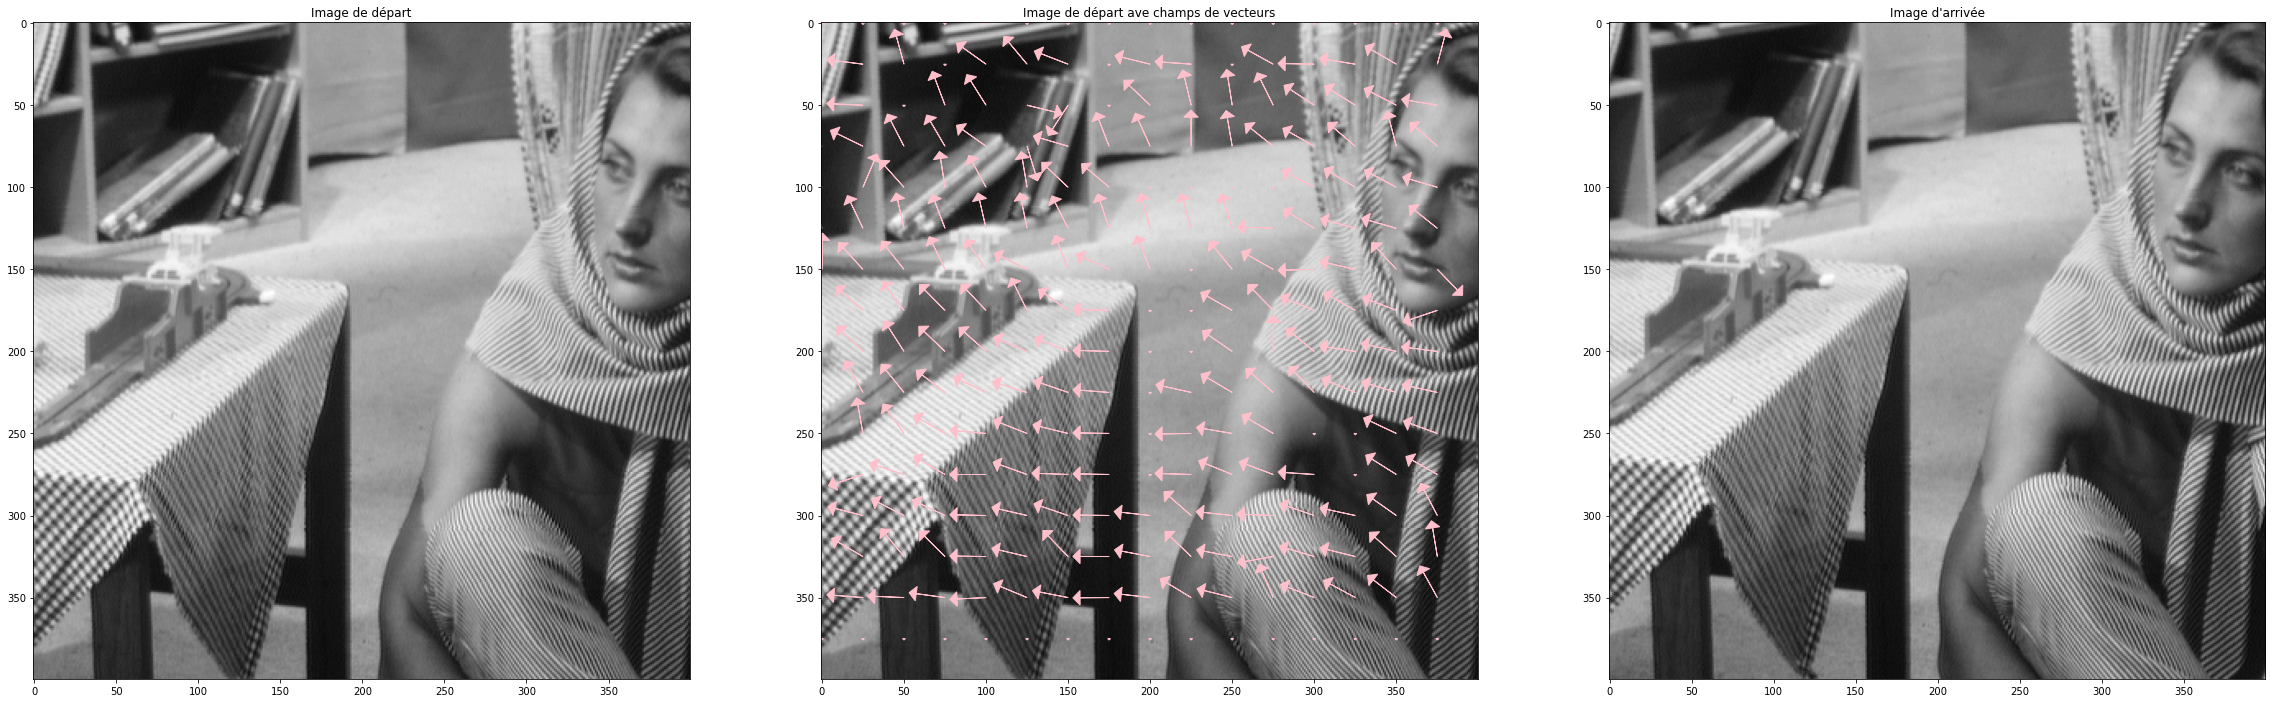

In [11]:
plt.figure(figsize = (40,15))
plt.subplot(1,3,1)
plt.imshow(v1,cmap='gray')
plt.title("Image de départ")
plt.subplot(1,3,2)
draw_arrows(v1,t_vc,25,1,1,100,1,1)
plt.title("Image de départ ave champs de vecteurs")
plt.subplot(1,3,3)
plt.imshow(v2,cmap='gray')
plt.title("Image d'arrivée")
plt.show()

##### $\lambda = 1000$

In [12]:
Lambda = 1000
t_vc1,norm_grad_vc1 = descente_grad(v1,v2,10**(-6),100,0.01,Lambda)

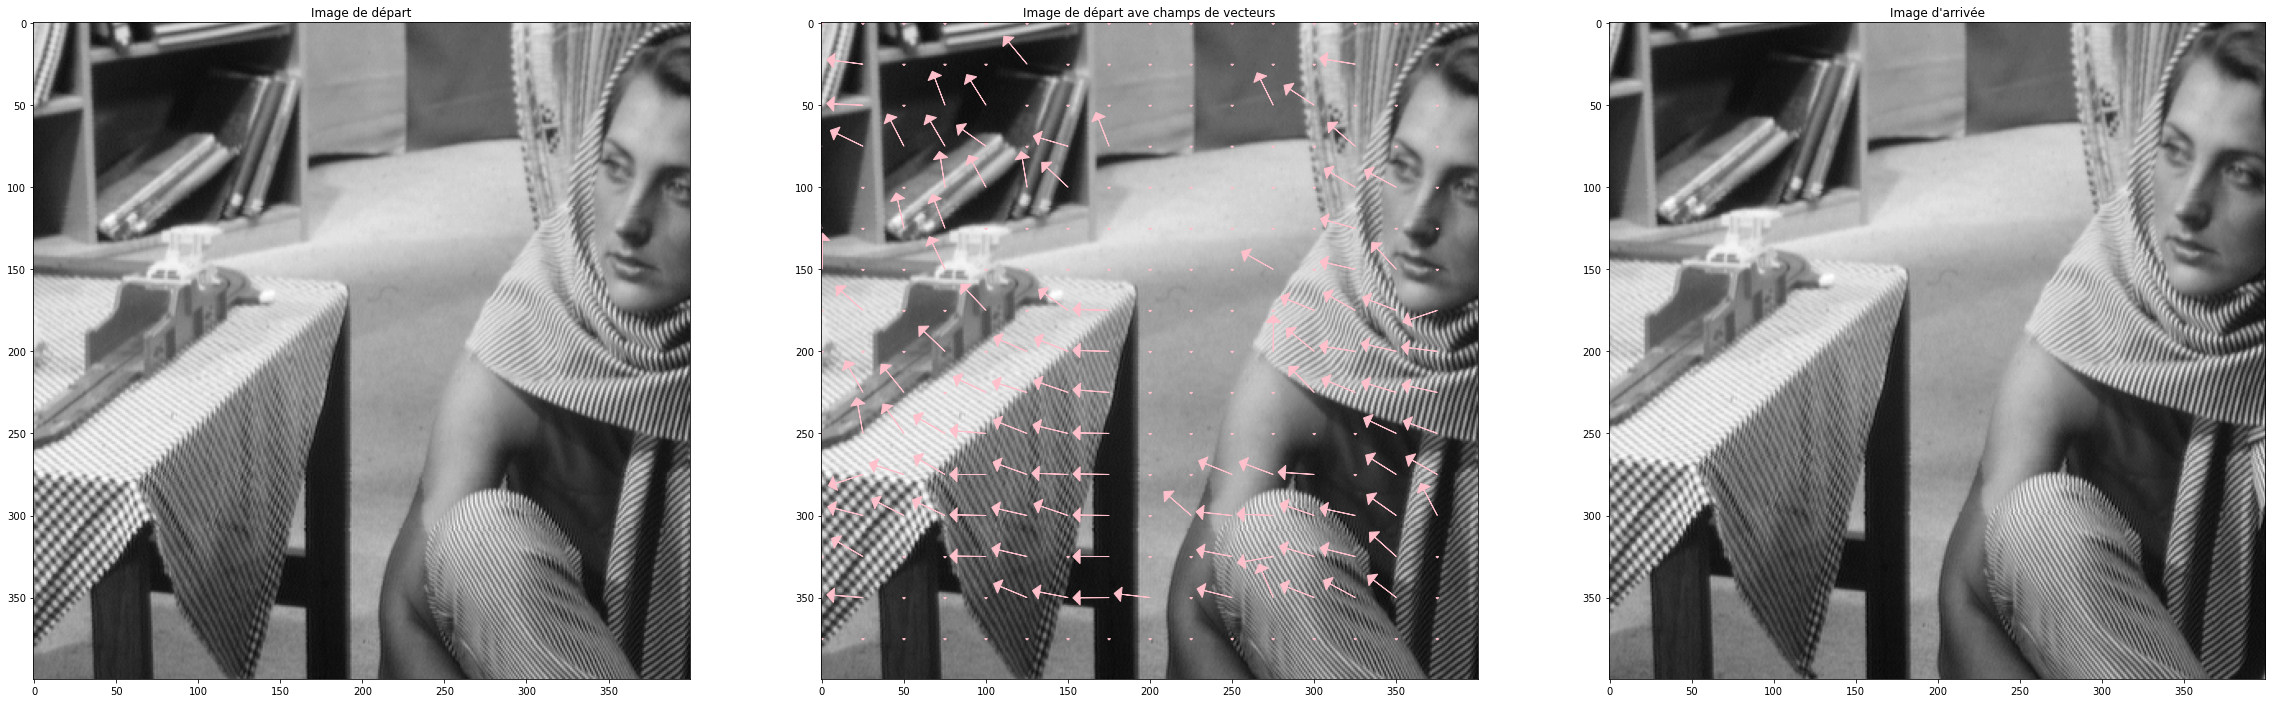

In [13]:
plt.figure(figsize = (40,15))
plt.subplot(1,3,1)
plt.imshow(v1,cmap='gray')
plt.title("Image de départ")
plt.subplot(1,3,2)
draw_arrows(v1,t_vc1,25,1,1,100,1,1)
plt.title("Image de départ ave champs de vecteurs")
plt.subplot(1,3,3)
plt.imshow(v2,cmap='gray')
plt.title("Image d'arrivée")
plt.show()

#### Test avec pas d'Armijo

##### $ \lambda = 100$

In [142]:
Lambda = 100
t_va,norm_grad_va,func_ba = descente_gradA(v1,v2,10,0.01,Lambda)

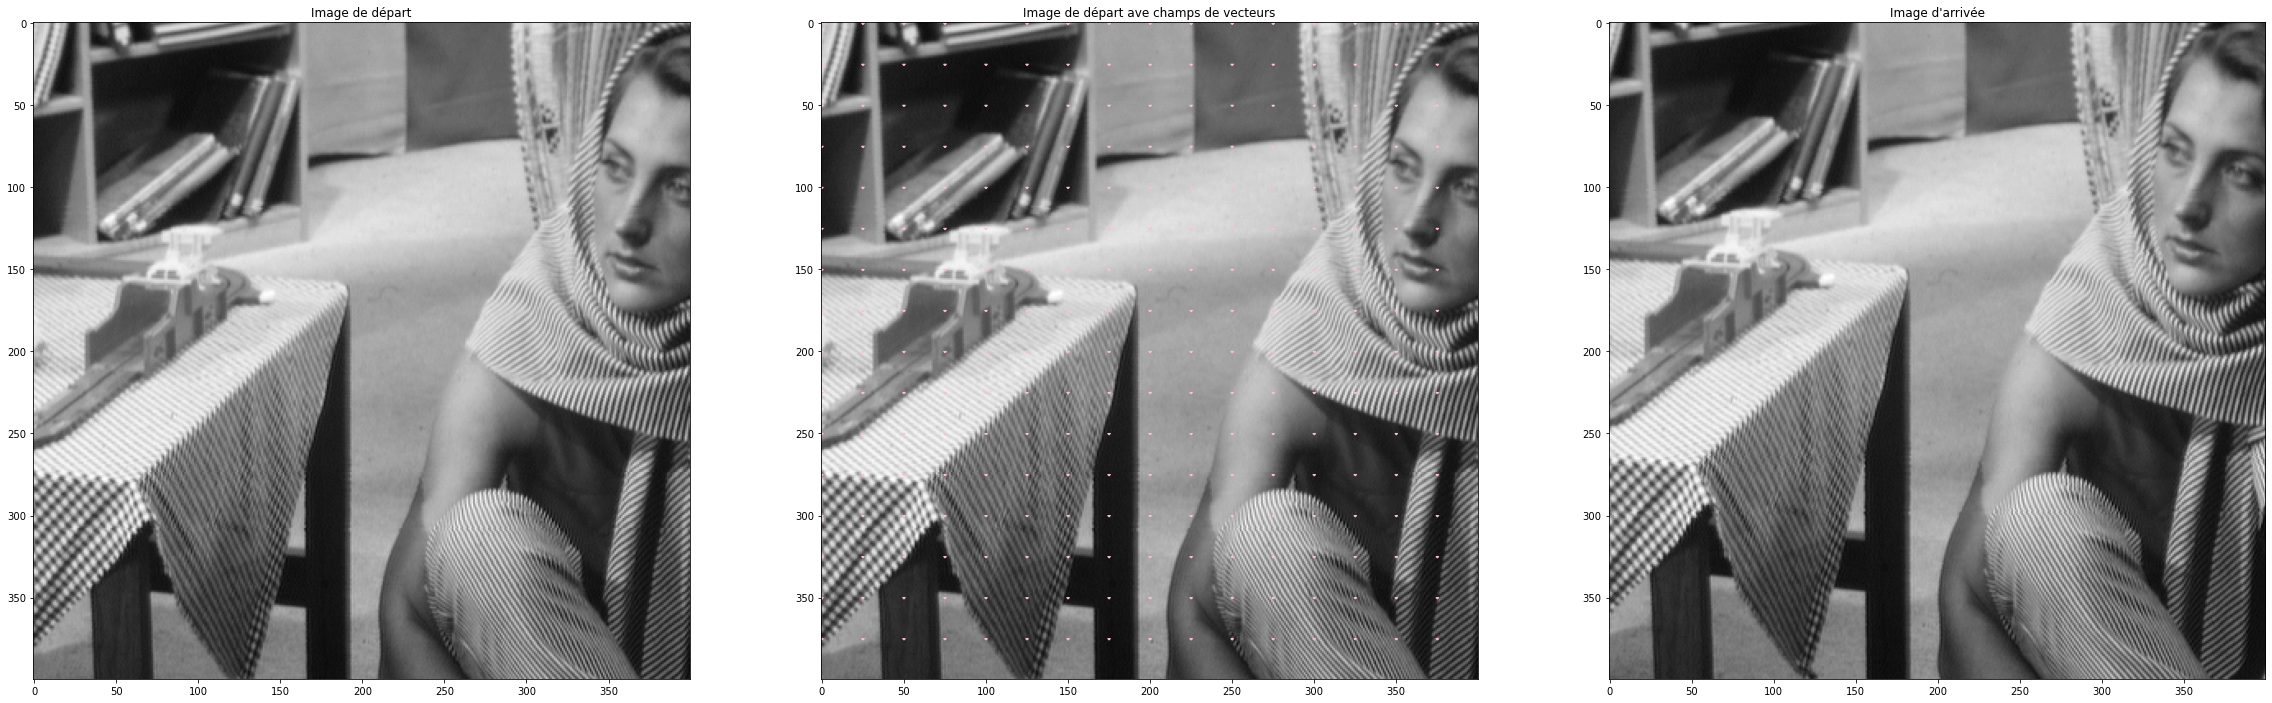

In [143]:
plt.figure(figsize = (40,15))
plt.subplot(1,3,1)
plt.imshow(v1,cmap='gray')
plt.title("Image de départ")
plt.subplot(1,3,2)
draw_arrows(v1,t_va,25,1,1,100,1,1)
plt.title("Image de départ ave champs de vecteurs")
plt.subplot(1,3,3)
plt.imshow(v2,cmap='gray')
plt.title("Image d'arrivée")
plt.show()

#### Convergence des gradients

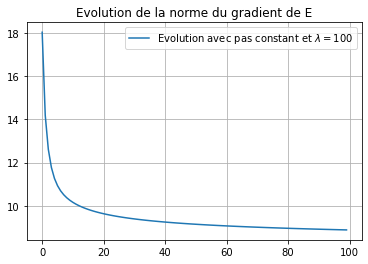

In [123]:
N = np.array([len(norm_grad_vc),len(norm_grad_vc1),len(norm_grad_va)])
plt.title("Evolution de la norme du gradient de E")
plt.plot(range(N[0]),norm_grad_vc,label="Evolution avec pas constant et $\lambda = 100$")
plt.grid()
plt.legend()

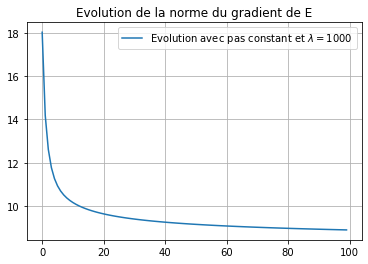

In [148]:
plt.title("Evolution de la norme du gradient de E")
plt.plot(range(N[1]),norm_grad_vc1,label="Evolution avec pas constant et $\lambda = 1000$")
plt.grid()
plt.legend()

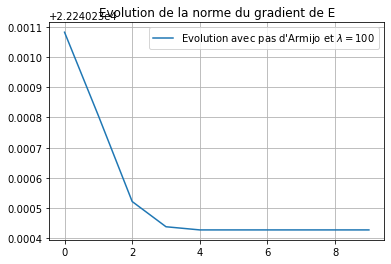

In [149]:
plt.title("Evolution de la norme du gradient de E")
plt.plot(range(10),func_ba,label="Evolution avec pas d'Armijo et $\lambda = 100$")
plt.grid()
plt.legend()

### Décalage de Jack

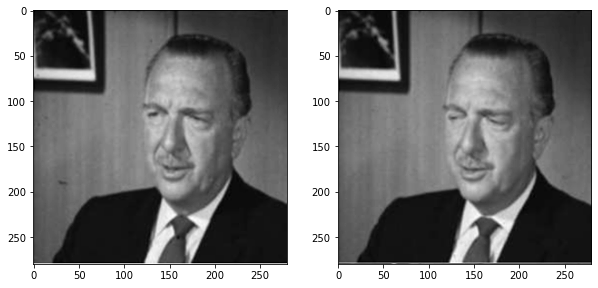

In [48]:
#image 1 
j1 = mpimg.imread("Image1.png")
Ro,G,B = j1[:,:,0] , j1[:,:,1] , j1[:,:,2]
j1 = 0.2989*Ro + 0.587*G + 0.114*B
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(j1,cmap='gray')
#image 2
j2 = mpimg.imread("Image2.png")
Ro,G,B = j2[:,:,0] , j2[:,:,1] , j2[:,:,2]
j2 = 0.2989*Ro + 0.587*G + 0.114*B
plt.subplot(1,2,2)
plt.imshow(j2,cmap='gray')
plt.show()

#### Test avec pas constant

##### $ \lambda = 100$

In [49]:
Lambda = 100
t_jc,norm_grad_jc = descente_grad(j1,j2,10**(-6),100,0.01,Lambda)

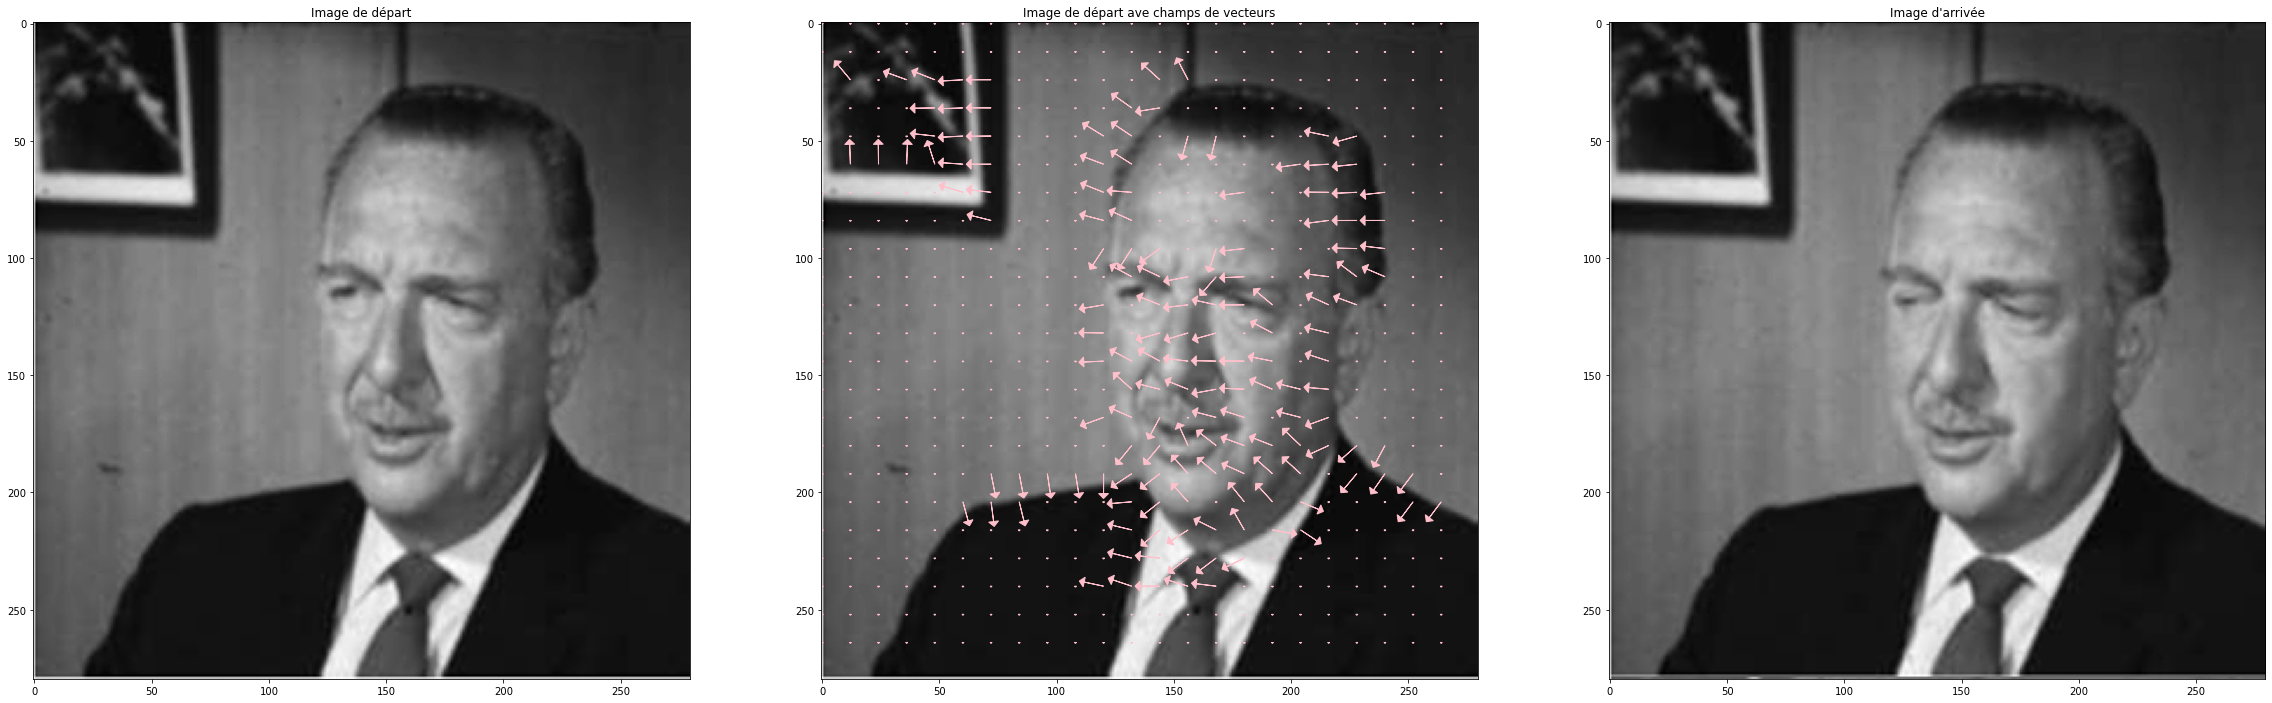

In [55]:
plt.figure(figsize = (40,15))
plt.subplot(1,3,1)
plt.imshow(j1,cmap='gray')
plt.title("Image de départ")
plt.subplot(1,3,2)
draw_arrows(j1,t_jc,12,1,1,100,1,1)
plt.title("Image de départ ave champs de vecteurs")
plt.subplot(1,3,3)
plt.imshow(j2,cmap='gray')
plt.title("Image d'arrivée")
plt.show()

##### $ \lambda = 500$

In [135]:
Lambda = 500
t_jc1,norm_grad_jc1 = descente_grad(j1,j2,10**(-6),100,0.01,Lambda)

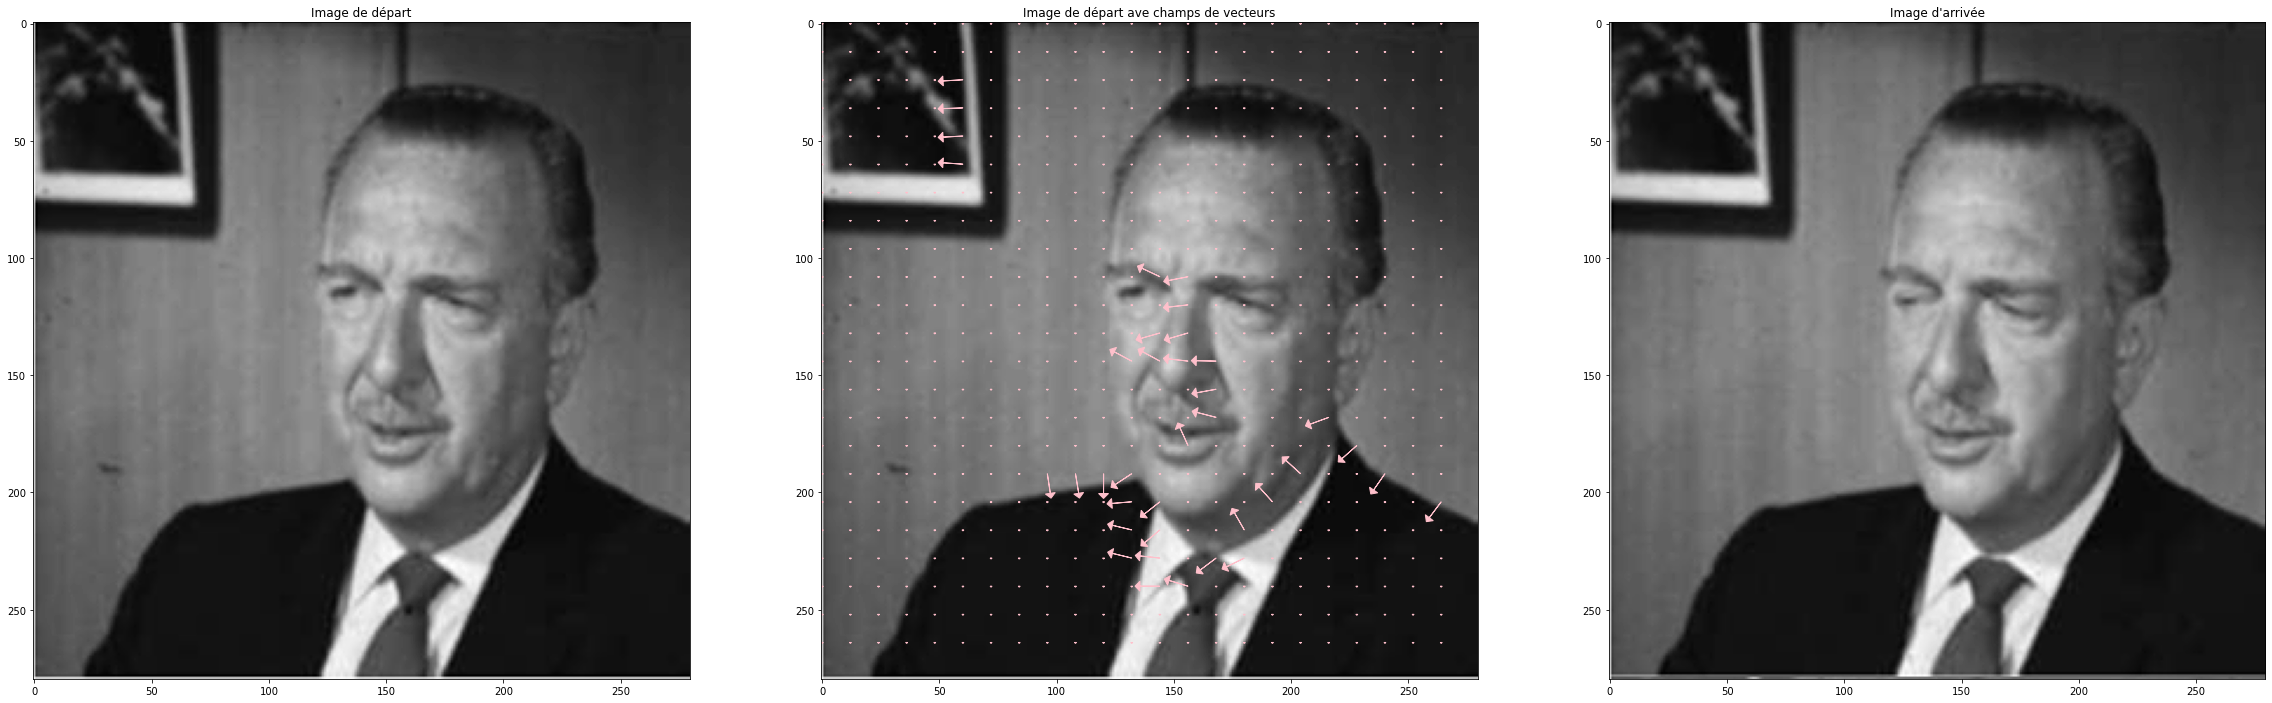

In [136]:
plt.figure(figsize = (40,15))
plt.subplot(1,3,1)
plt.imshow(j1,cmap='gray')
plt.title("Image de départ")
plt.subplot(1,3,2)
draw_arrows(j1,t_jc1,12,1,1,100,1,1)
plt.title("Image de départ ave champs de vecteurs")
plt.subplot(1,3,3)
plt.imshow(j2,cmap='gray')
plt.title("Image d'arrivée")
plt.show()

#### Test avec pas d'Armijo

##### $ \lambda = 100 $

In [128]:
Lambda = 100
t_ja,norm_grad_ja,func_ja = descente_gradA(j1,j2,20,10**(-6),Lambda)

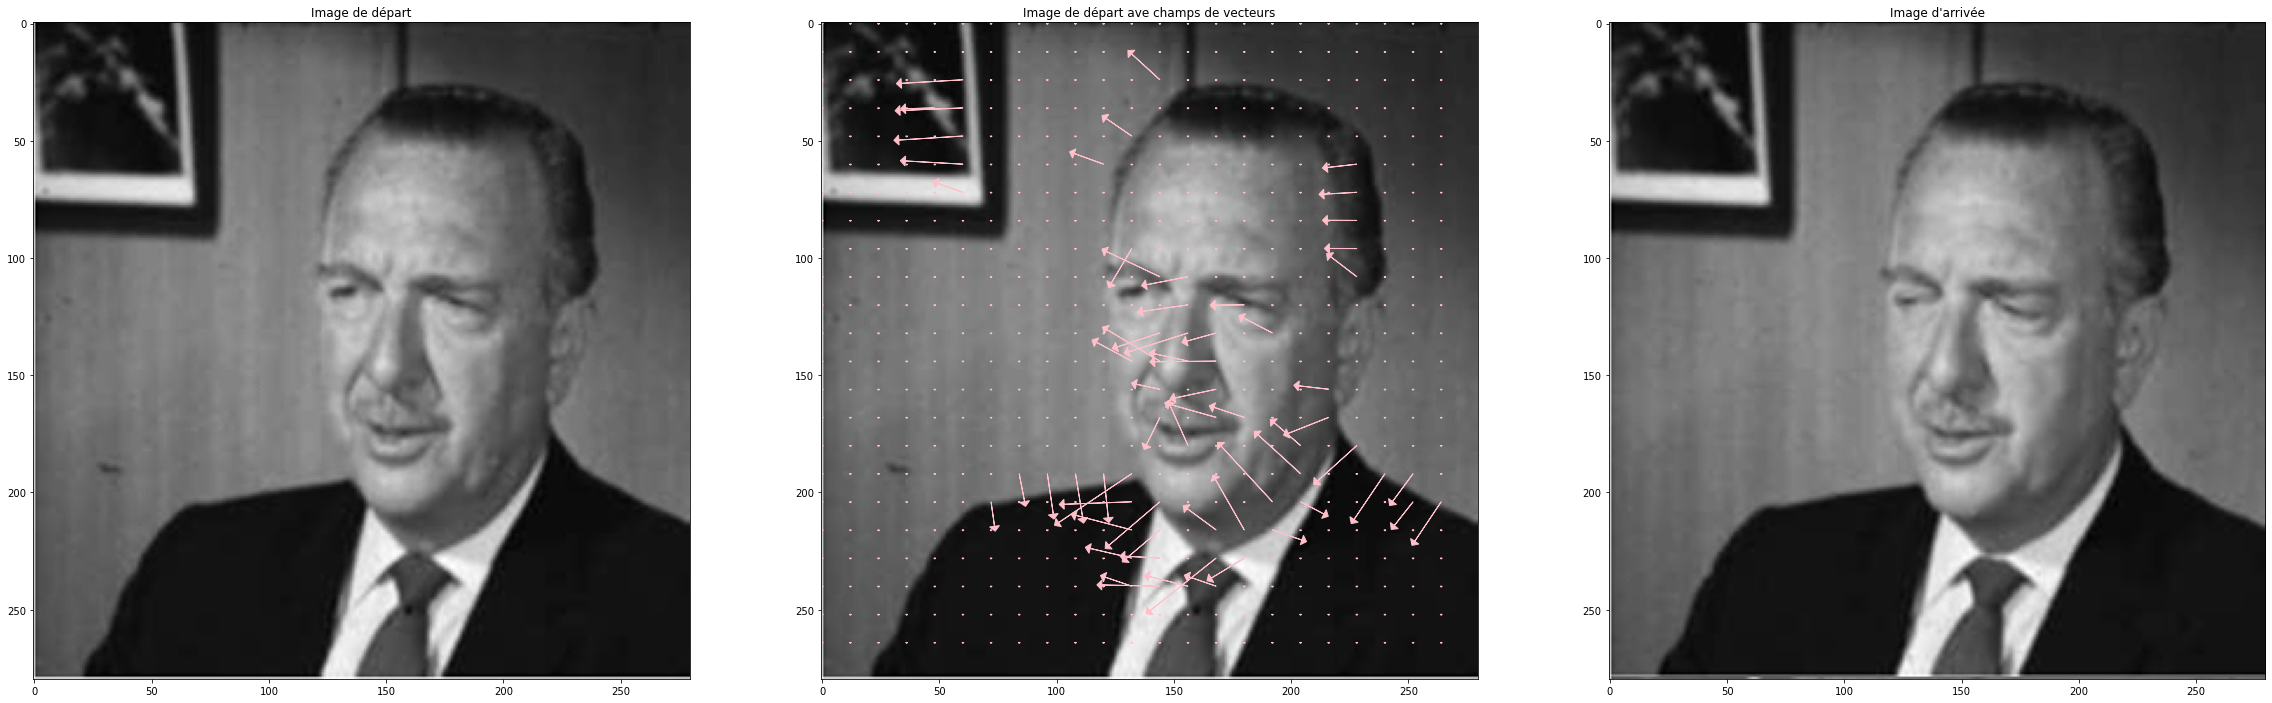

In [129]:
plt.figure(figsize = (40,15))
plt.subplot(1,3,1)
plt.imshow(j1,cmap='gray')
plt.title("Image de départ")
plt.subplot(1,3,2)
draw_arrows(j1,t_ja,12,0.5,1,100,1,0)
plt.title("Image de départ ave champs de vecteurs")
plt.subplot(1,3,3)
plt.imshow(j2,cmap='gray')
plt.title("Image d'arrivée")
plt.show()

#### Convergence des gradients

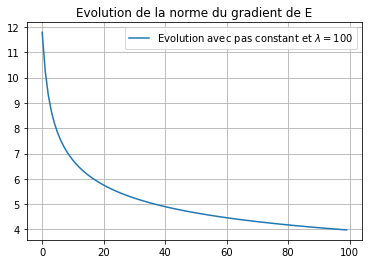

In [115]:
N = np.array([len(norm_grad_jc),len(norm_grad_jc1),len(norm_grad_ja)])
plt.title("Evolution de la norme du gradient de E")
plt.plot(range(N[0]),norm_grad_jc,label="Evolution avec pas constant et $\lambda = 100$")
plt.grid()
plt.legend()

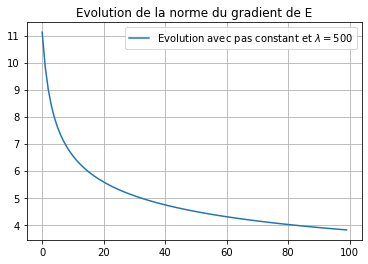

In [138]:
plt.title("Evolution de la norme du gradient de E")
plt.plot(range(N[1]),norm_grad_jc1,label="Evolution avec pas constant et $\lambda = 500$")
plt.grid()
plt.legend()

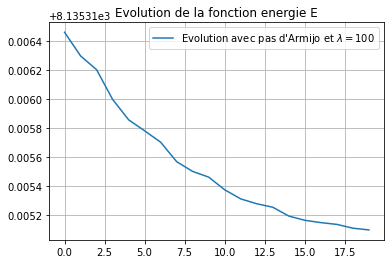

In [137]:
plt.title("Evolution de la fonction energie E")
plt.plot(range(20),func_ja,label="Evolution avec pas d'Armijo et $\lambda = 100$")
plt.grid()
plt.legend()

### Stylo

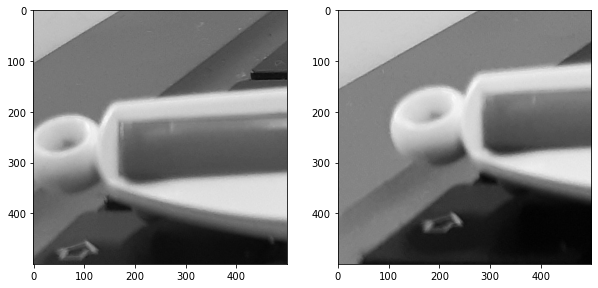

In [84]:
#image 1
s1 = mpimg.imread("Stylo1.jpg")[1500:2000,400:900]
Ro,G,B = s1[:,:,0] , s1[:,:,1] , s1[:,:,2]
s1 = 0.2989*Ro + 0.587*G + 0.114*B
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(s1,cmap='gray')
#image 2
s2 = mpimg.imread("Stylo2.jpg")[1500:2000,0:500]
Ro,G,B = s2[:,:,0] , s2[:,:,1] , s2[:,:,2]
s2 = 0.2989*Ro + 0.587*G + 0.114*B
plt.subplot(1,2,2)
plt.imshow(s2,cmap='gray')
plt.show()

#### Test avec pas constant

##### $ \lambda = 500$

In [139]:
Lambda = 500
t_sc,norm_grad_sc = descente_grad(s1,s2,10**(-6),100,0.01,Lambda)

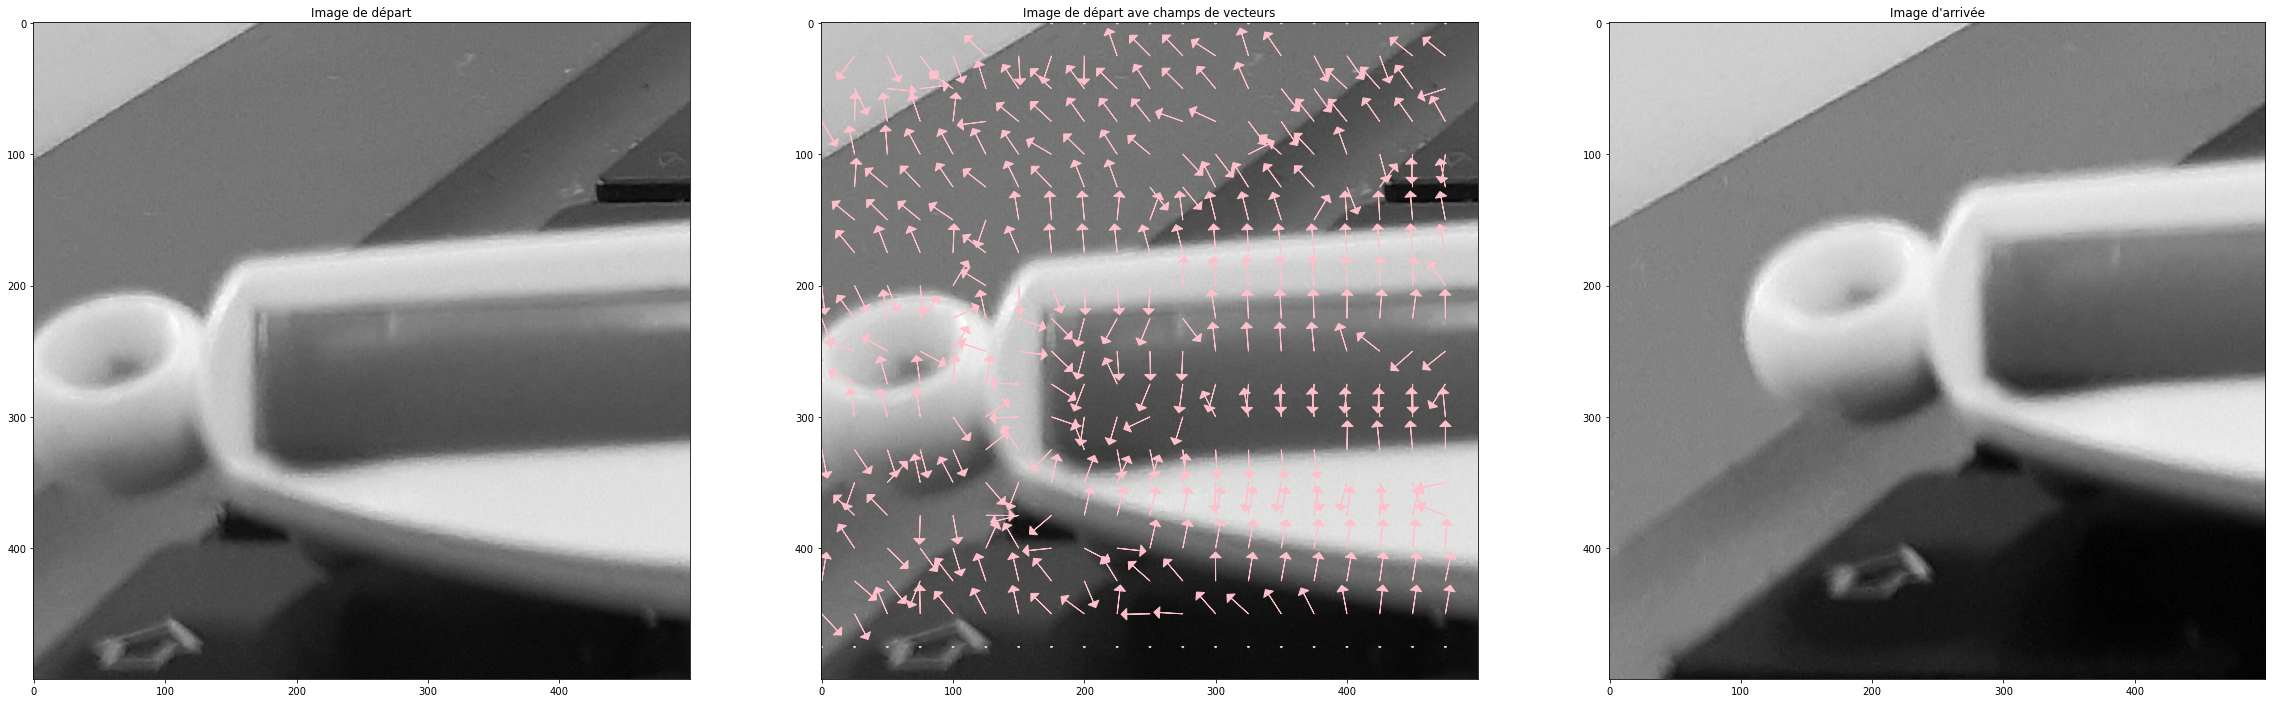

In [140]:
plt.figure(figsize = (40,15))
plt.subplot(1,3,1)
plt.imshow(s1,cmap='gray')
plt.title("Image de départ")
plt.subplot(1,3,2)
draw_arrows(s1,t_sc,25,1,1,100,1,1)
plt.title("Image de départ ave champs de vecteurs")
plt.subplot(1,3,3)
plt.imshow(s2,cmap='gray')
plt.title("Image d'arrivée")
plt.show()

##### $ \lambda = 1000 $

In [88]:
Lambda = 1000
t_sc1,norm_grad_sc1 = descente_grad(s1,s2,10**(-6),100,0.01,Lambda)

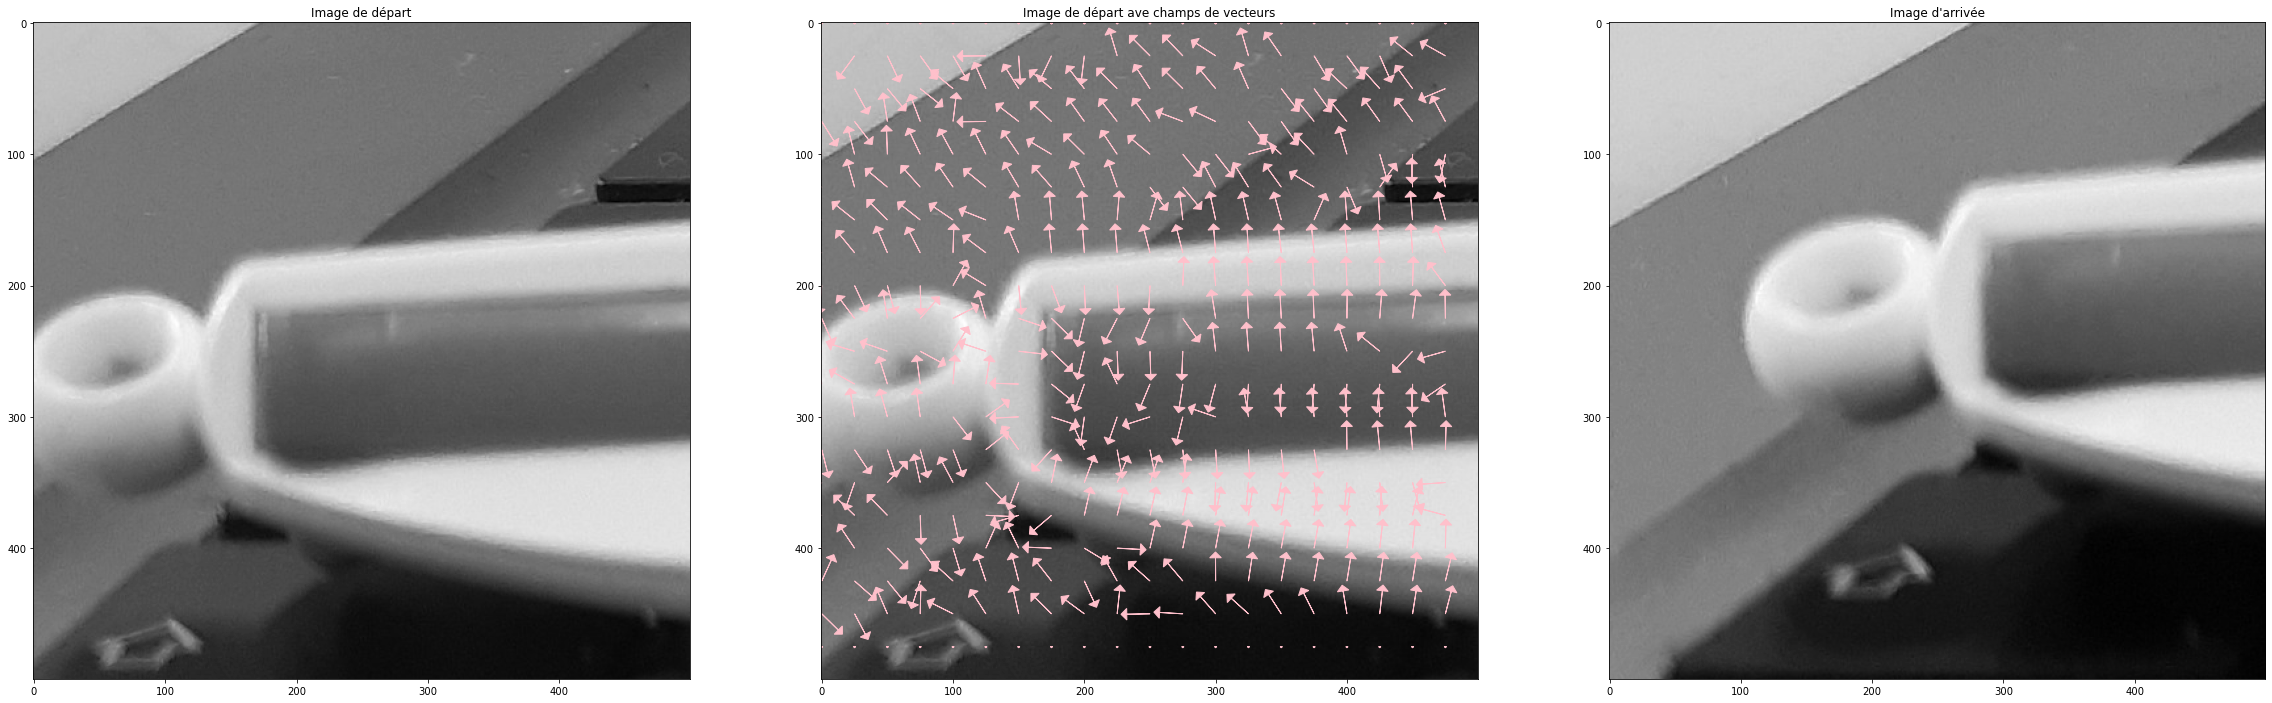

In [89]:
plt.figure(figsize = (40,15))
plt.subplot(1,3,1)
plt.imshow(s1,cmap='gray')
plt.title("Image de départ")
plt.subplot(1,3,2)
draw_arrows(s1,t_sc1,25,1,1,100,1,1)
plt.title("Image de départ ave champs de vecteurs")
plt.subplot(1,3,3)
plt.imshow(s2,cmap='gray')
plt.title("Image d'arrivée")
plt.show()

#### Test avec pas d'Armijo

##### $ \lambda = 100$

In [131]:
Lambda = 100
t_sa,norm_grad_sa,func_sa = descente_gradA(s1,s2,20,0.01,Lambda)

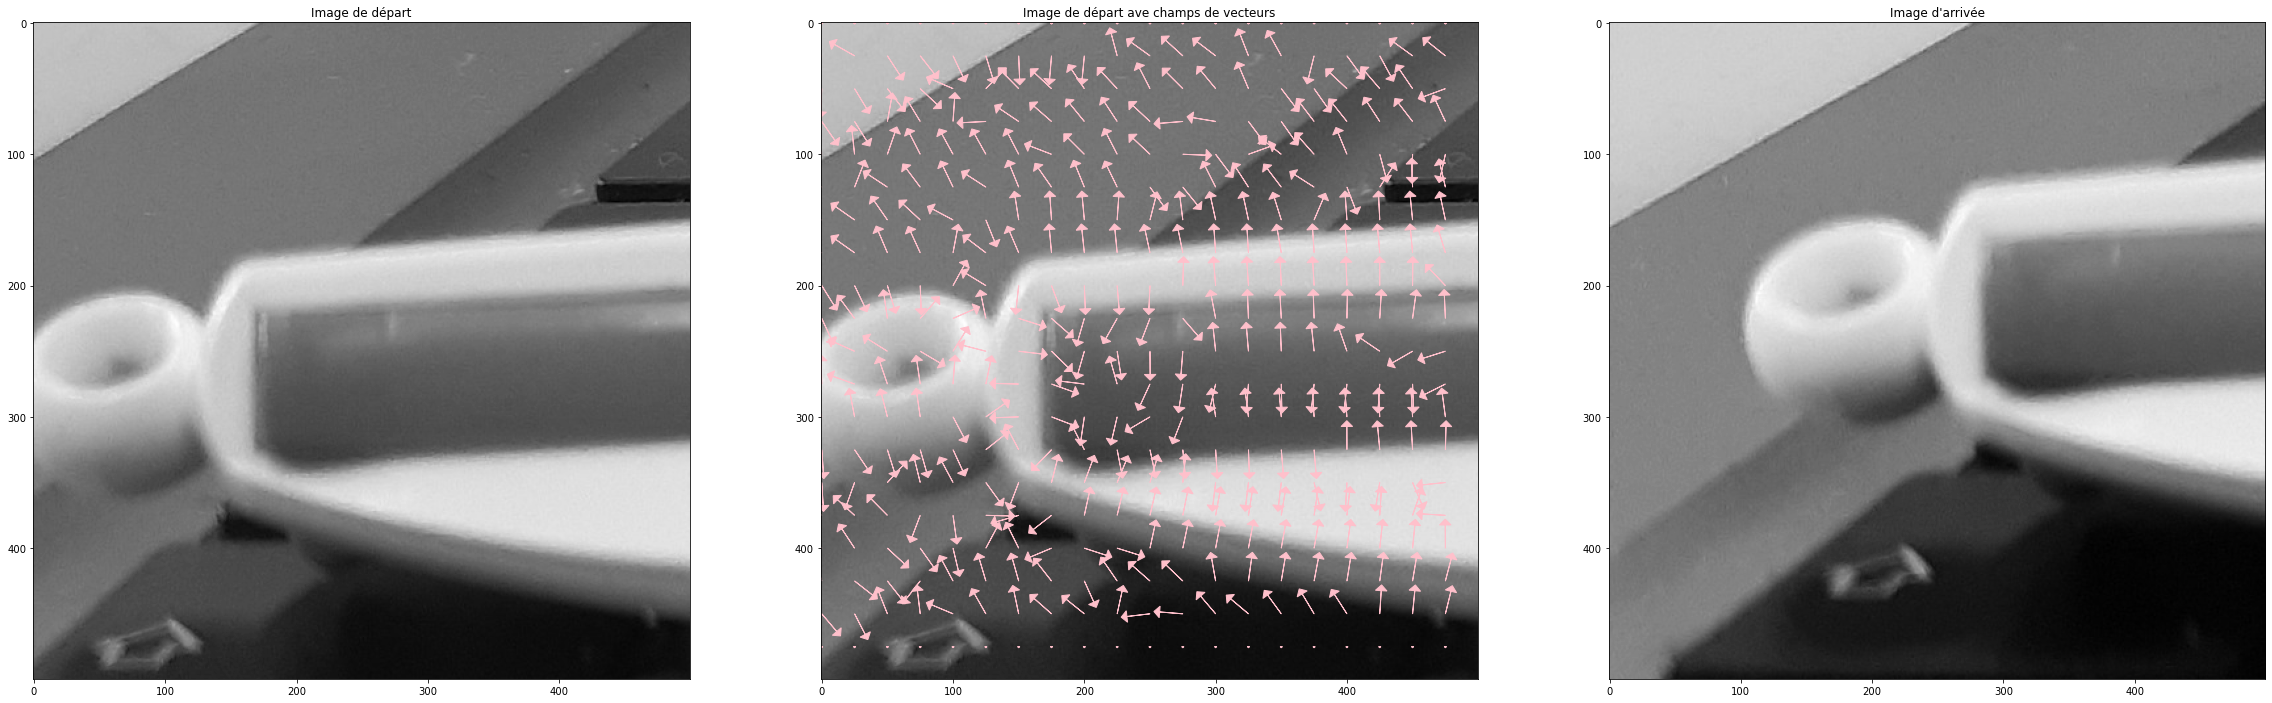

In [132]:
plt.figure(figsize = (40,15))
plt.subplot(1,3,1)
plt.imshow(s1,cmap='gray')
plt.title("Image de départ")
plt.subplot(1,3,2)
draw_arrows(s1,t_sa,25,1,1,100,1,1)
plt.title("Image de départ ave champs de vecteurs")
plt.subplot(1,3,3)
plt.imshow(s2,cmap='gray')
plt.title("Image d'arrivée")
plt.show()

#### Convergence des gradients

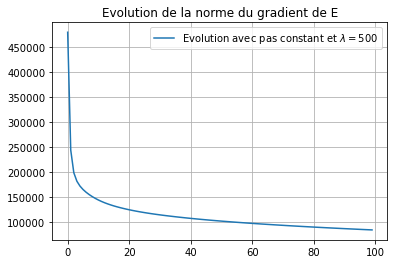

In [141]:
N = np.array([len(norm_grad_sc),len(norm_grad_sc1),len(norm_grad_sa)])
plt.title("Evolution de la norme du gradient de E")
plt.plot(range(N[0]),norm_grad_sc,label="Evolution avec pas constant et $\lambda = 500$")
plt.grid()
plt.legend()

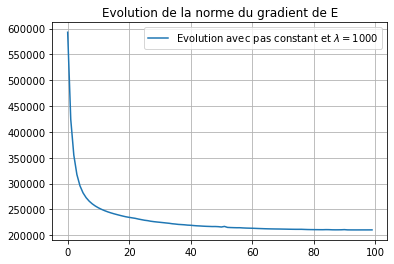

In [94]:
plt.title("Evolution de la norme du gradient de E")
plt.plot(range(N[1]),norm_grad_sc1,label="Evolution avec pas constant et $\lambda = 1000$")
plt.grid()
plt.legend()

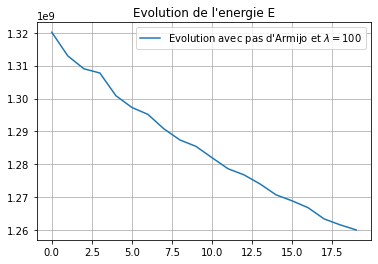

In [134]:
plt.title("Evolution de l'energie E")
plt.plot(range(N[2]),func_sa,label="Evolution avec pas d'Armijo et $\lambda = 100$")
plt.grid()
plt.legend()